## Importing all the relevant libraries

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

## Creating folders for training data/anchor data

Anchor data is the all the real time images taken from the webcam

These are just the paths that have been defined that link the data and positive folder etc

Positive folder is going to contain several images of my face

Negative folder is going to contain several images of other people's faces

### Defining the directories

In [2]:
pos_path = os.path.join('data', 'positive')
neg_path = os.path.join('data', 'negative')
anc_path = os.path.join('data', 'anchor')

### Creating the directories using the paths defined above

In [4]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

### Importing random faces

Website: http://vis-www.cs.umass.edu/lfw/

Below uncompresses the TAR files dataset

In [1]:
!tar -xf lfw.tgz

#### Adding the random faces to the negative folder

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        ex_path = os.path.join('lfw', directory, file)
        new_path = os.path.join(neg_path, file)
        os.replace(ex_path, new_path)

In [4]:
import uuid

In [5]:
os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1))

'data\\anchor\\<function uuid1 at 0x000002707B3A3CE0>.jpg'

# Capturing images via webcam

## Populating the positive folder and capturing anchor images

In [7]:
# creating a connection to the webcam
cap = cv2.VideoCapture(0)
# loops through every frame in our webcam
while cap.isOpened():
#     cap.read() reads a capture at a point in time and creates a frame (and a return value)
    ret, frame = cap.read()
    
    frame = frame[120:120 + 250, 200:200 + 250, :]

    # collecting anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        # writes out the anchor image
        cv2.imwrite(imgname, frame)
    
    # collecting images for the positive dataset
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
#     This shows image taken on the screen
    cv2.imshow('Image Collection', frame)
    
# This ends the webcam. It waits 1 second and the ends when the key 'q' is pressed
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# releases the webcam
cap.release()
cv2.destroyAllWindows()

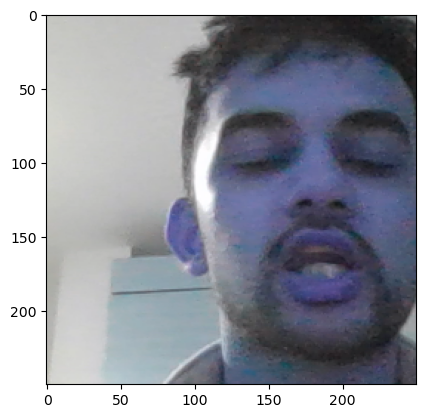

In [8]:
plt.imshow(frame)

## Loading images from directories

In [3]:
anchor = tf.data.Dataset.list_files(anc_path+'\*.jpg').take(300) # taking every file ending in the wildcard '*.jpg' 
positive = tf.data.Dataset.list_files(pos_path + '\*.jpg').take(300) 
negative = tf.data.Dataset.list_files(neg_path+'\*.jpg').take(300)

#### Converting a file into a numpy iterator that is stored as numpy array 

In [4]:
anchor.as_numpy_iterator()

In [5]:
dir_test = anchor.as_numpy_iterator()

In [6]:
dir_test.next()

b'data\\anchor\\29d0081d-b957-11ee-99f0-ca5f2ab20ebf.jpg'

# Defining the pre-process function for images

In [7]:
def preprocess_images(file_path):
    
#     reads in the image
    byte_img = tf.io.read_file(file_path)
#     turns this into an image
    img = tf.io.decode_jpeg(byte_img)
#     resizing the image to be 100 pixels each way and 3 colour channels
    img = tf.image.resize(img, (100, 100))
#     scales images to range between 0 and 1 to imporove performance of the model when it comes to the loss function
#     gradient descent
    img = img * 1.0 / 255
    
    return img

In [8]:
image1 = preprocess_images('data\\anchor\\2a9d5317-b957-11ee-a64f-ca5f2ab20ebf.jpg')

### Viewing the output of the pre-process function

In [9]:
image1.numpy()[1]

array([[0.38186276, 0.43676472, 0.4406863 ],
       [0.39387256, 0.44877452, 0.45171568],
       [0.38627452, 0.44117647, 0.44117647],
       [0.38431373, 0.44019607, 0.4372549 ],
       [0.37965685, 0.43553922, 0.43259802],
       [0.3855392 , 0.44117647, 0.43970588],
       [0.3882353 , 0.44166666, 0.44166666],
       [0.389951  , 0.4370098 , 0.43504903],
       [0.3997549 , 0.44387254, 0.4497549 ],
       [0.40686274, 0.44607842, 0.4522059 ],
       [0.4117647 , 0.4509804 , 0.45490196],
       [0.40392157, 0.44313726, 0.44705883],
       [0.39779413, 0.4370098 , 0.44093138],
       [0.3987745 , 0.44387254, 0.4370098 ],
       [0.40980393, 0.44607842, 0.4362745 ],
       [0.41691175, 0.44338235, 0.4345588 ],
       [0.41789216, 0.44436276, 0.43553922],
       [0.41642156, 0.44411764, 0.44534314],
       [0.40514705, 0.4365196 , 0.44730392],
       [0.40367648, 0.44289216, 0.4507353 ],
       [0.41887254, 0.45808825, 0.4659314 ],
       [0.40661764, 0.43995097, 0.4507353 ],
       [0.

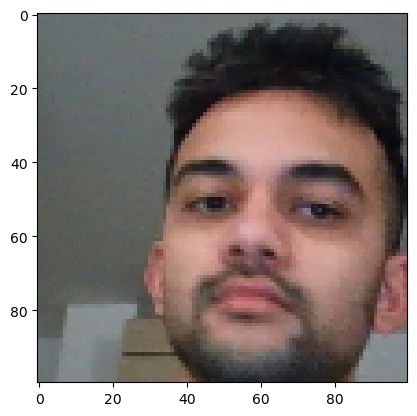

In [10]:
plt.imshow(image1)

In [11]:
dataset.map(preprocess_images)

NameError: name 'dataset' is not defined

## Create a labelled dataset ('data') including positives and negatives

In [12]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))).as_numpy_iterator()

class_labels.next()

0.0

#### The dataset currently contains positives first and then negatives. It needs a shuffle

In [14]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
dataset_example = data.as_numpy_iterator()

example = dataset_example.next()

## Defining a function that pre-processes the input and validation image

In [16]:
def preprocess_twin(input_image, validation_image, label):
    return(preprocess_images(input_image), preprocess_images(validation_image), label)

In [17]:
res = preprocess_twin(*example)

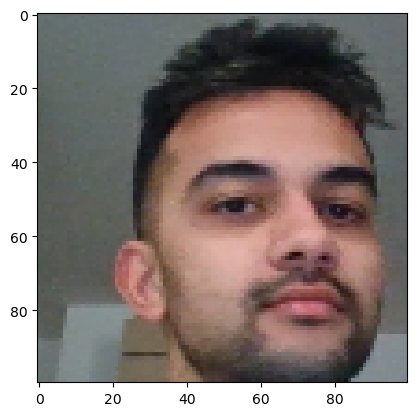

In [18]:
plt.imshow(res[0])

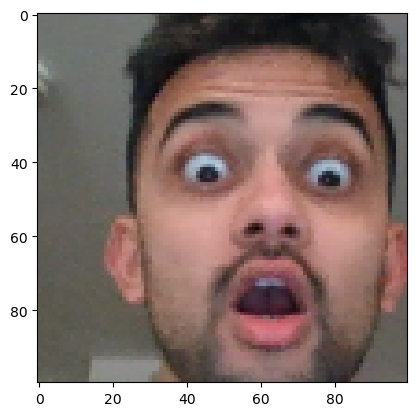

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

1.0

## Building a dataloader pipeline

In [21]:
data = data.map(preprocess_twin)
data = data.cache()
data= data.shuffle(buffer_size = 1024) # buffer size is the sample size that's taken and is shuffled

In [22]:
sample = data.as_numpy_iterator() # turns the files into numpy arrays

In [23]:
result1 = sample.next()

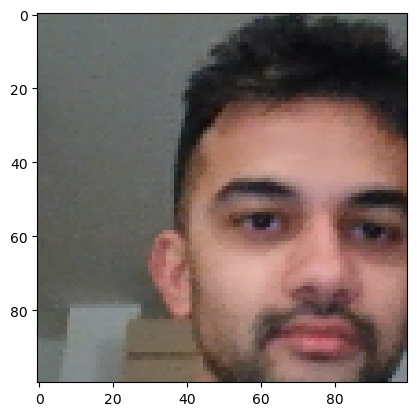

In [24]:
plt.imshow(result1[0])

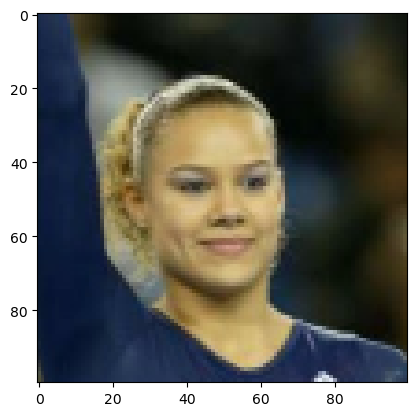

In [25]:
plt.imshow(result1[1])

In [26]:
result1[2]

0.0

## Splitting dataset into train and test data; 70/30 split

### Train data

In [27]:
train_data = data.take(round(len(data) * 0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

### Testing/Validation data

In [28]:
test_data = data.skip(round(len(data) * 0.7))
test_data = test_data.take(round(len(data) * 0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Building the CNN model

Building the embedding layer

In [34]:
inp = Input((100, 100, 3), name = 'input_shape')

In [ ]:
c1 = Conv2D(64, (10, 10), activation = 'relu')(c1)

In [ ]:
m1 = MaxPooling(64, (2, 2), padding = 'same')(c1)

In [ ]:
c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)

In [ ]:
m2 = MaxPooling(64, (2, 2), padding = 'same')(c2)

## Building embedding layer

#### The below model will convolute the images to highlight the distinct features. The MaxPooling layer will extract the maximum value of a specific region of the image. As a certain kernel size is specified, this layer will extract the maximum value of the area as this kernel propogates throughout the image tensor. 

In [29]:
def make_embedding():
    #declaring the input shape and name of the model
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    
    #defining the first block of layers
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(62, (2, 2), padding = 'same')(c1)
    
    # defining second layer
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = 'same')(c2)
    
    # defining third layer
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = 'same')(c3)
    
    # final layer
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs = [inp], outputs = [d1], name = 'embedding')


In [30]:
embedding = make_embedding()

embedding.summary()



Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       

## Distance layer

This layer will now compare the two outputs of the model above. 

Both the anchor image and the positive/negative image will be processed alongside each other. The below function will determine the similarity between the two.

In [31]:
# Siamese L1 distance class
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
            return tf.math.abs(input_embedding - validation_embedding)

## Constructing the Siamese model

### Aggregating all our abstract functions/classes to form the Siamese CNN model

In [32]:
def siamese_model():
    # handling inputs
    # this is the anchor image
    input_image = Input(name = 'input_image', shape = (100, 100, 3))
    
    # this is the validation image
    validation_image = Input(name = 'validation_image', shape = (100, 100, 3))
    
    # combine the distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation = 'sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'Siamese_Network')

In [33]:
siamese_model = siamese_model()

### Defining the loss function and the optimizer

In [34]:
loss_func = tf.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(0.0004) # specifying the optimizer's learning rate

## Configuring the model checkpoints 

In [35]:
checkpoint_folder = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_folder + 'ckpt')
checkpoint = tf.train.Checkpoint(opt = optimizer, siamese_model = siamese_model)

### Defining the train step function

In [36]:
@tf.function

def train_step(batch):
    
    with tf.GradientTape() as tape:
        
        # the batch contains batches of 16 images that have a shape of (100, 100, 3) and their label
        # X now pulls the anchor image and the positive/negative image
        X = batch[:2]
        # this pulls the corresponding label
        y_true = batch[2]
        
        y_pred = siamese_model(X, training = True)
        
        loss = loss_func(y_true, y_pred)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

### Building the training loop

In [37]:
def train(train_data, EPOCHS):
    
    for epoch in range(1, EPOCHS):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        for idx, batch in enumerate(train_data):
            #the train step runs here
            train_step(batch)
            progbar.update(idx+1)
            
#             saving checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

### Training the model

In [38]:
EPOCHS = 50

In [39]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 257s 9s/step

 Epoch 2/50
27/27 [==============================] - 232s 9s/step

 Epoch 3/50
27/27 [==============================] - 243s 9s/step

 Epoch 4/50
27/27 [==============================] - 253s 9s/step

 Epoch 5/50
27/27 [==============================] - 258s 10s/step

 Epoch 6/50
27/27 [==============================] - 246s 9s/step

 Epoch 7/50
27/27 [==============================] - 244s 9s/step

 Epoch 8/50
27/27 [==============================] - 248s 9s/step

 Epoch 9/50
27/27 [==============================] - 241s 9s/step

 Epoch 10/50
27/27 [==============================] - 194s 7s/step

 Epoch 11/50
27/27 [==============================] - 240s 9s/step

 Epoch 12/50
27/27 [==============================] - 239s 9s/step

 Epoch 13/50
27/27 [==============================] - 226s 8s/step

 Epoch 14/50
27/27 [==============================] - 229s 8s/step

 Epoch 15/50
27/27 [==============================] - 2

### Testing the model

In [40]:
from tensorflow.keras.metrics import Precision, Recall

In [41]:
test_input, test_val, y_pred = test_data.as_numpy_iterator().next()

In [42]:
y_pred = siamese_model.predict([test_input, test_val])

y_pred

1/1 [==============================] - 6s 6s/step


array([[0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734],
       [0.5110734]], dtype=float32)

In [72]:
# need to classify the output to either a match or not a match (1 or 0)
binary_result = [1 if prediction > 0.5 else 0 for prediction in y_pred]

In [1]:
# calculating the recall value
recall = Recall().update_state(y_true, y_pred)

# returns the recall result. Higher the number, the more accurate the model is. 
# It works out the overlap between the two arguments
recall.result().numpy()

## Visualising results

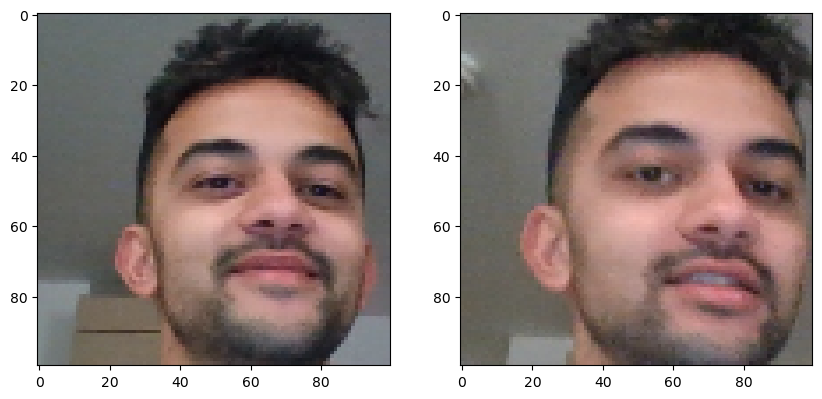

In [74]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])
plt.show()

In [ ]:
siamese_model.save('facialrecog1_siamesemodel.h5')

In [ ]:
model = tf.Keras.models.load_model('facialrecog1_siamesemodel.h5', 
                                  custom_objects = {'L1Dist':L1Dist, 
                                                   'BinaryCrossEntropy': tf.losses.BinaryCrossEntropy})

## Model Prediction & Summary

In [ ]:
model.predict([test_input, test_val])

In [ ]:
model.summary()

# Real Time Testing

The positive, negative and anchor images above are used for training purposes. To run a real time test, we need to create two folders. One folder to store the input images, another to store the verification images. The model will compare images in the input_images folder to the ones in the verification_images folder. 50 images in the verification folder means there'll be 50 different comparisons. Consequently, the model output will be a number between 0 and 1.

In this application, it's decided that a score over 0.5 is considered a positive prediction. The detection threshold is defined as the overlap score between the input image and the verification image.

The verification threshold is the proportion of comparisons that are past the detection threshold and the total number of comparisions. 

#### Creating the folders for input and verification images 

In [ ]:
application_data_path = os.path.join('application_data')
input_image_path = os.path.join(application_data_path, 'input_images')
verification_images_path = os.path.join(application_data_path, 'verification_images')

In [ ]:
application_data = os.makedirs(application_data_path)
input_image = os.makedirs(input_image_path)
verification_images = os.makedirs(verification_images_path)

## Verification Function

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
#     A comparison is made between the input image and each image in the validation images folder.
    for img in os.listdirs(verification_images_path):
        input_img = preprocess(os.listdirs(os.path.join(input_image_path, 'input_image.jpg')))
        validation_img = preprocess(os.listdirs(os.path.join(validation_images_path,img)))
        
#         Storing the result of the model prediction made from the comparison
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
#         Append results of each comparison to a list: 'results'
        results.append(result)
        
#         Calculating the detection threshold
        detection_threshold = np.sum(np.array(results) > detection_threshold)
#         Calculating the verification threshold, returns a Boolean
        verification = detection_threshold / len(os.listdirs(verification_images_path))
        
        verified_result = verification > verification_threshold
        
        return results, verified_result
    

## Real Time Verification using OpenCV

In [ ]:
cap = cv2. VideoCapture(0)
while cap.IsOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 120:120+150, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.WaitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join(input_image_path, 'input_image.jpg'), frame)
        results, verified_result = verify(model, 0.8, 0.8)
        print(verified_result)
        
    if cv2.WaitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cap.DestroyAllWindows()